# Simple Tren-Following strategy

## Background

Applying a Simple Tren-Following strategy, where trades are made based on the direction of recent price movements. In this specific case, the strategy is based on the percentage change in the OHLC (open, high, low, close) prices, with a buy signal generated if the percentage change is positive and a sell signal generated if the percentage change is negative.

---

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../functions_library')

from functions import ROC, model_selection

### Read the CSV file into Pandas DataFrame

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../Resources/ETHUSDT-1h-data.csv"), 
    index_col="timestamp", 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
trading_df.head()

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.0,301.61,125.66877,1502945999999,37684.804181,129,80.56377,24193.440789,0
2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67246,1502949599999,114043.282676,202,328.10428,99079.803569,0
2017-08-17 06:00:00,302.40,304.44,301.9,302.68,303.86672,1502953199999,92034.441294,182,259.28668,78525.948613,0
2017-08-17 07:00:00,302.68,307.96,302.6,307.96,754.74510,1502956799999,229725.136967,198,592.43176,180297.966961,0
2017-08-17 08:00:00,307.95,309.97,307.0,308.62,150.75029,1502960399999,46559.462371,182,140.68470,43451.495398,0


### Add a daily return values column to the DataFrame

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,actual_returns
timestamp,,,,,,,,,,,,
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,1502949599999,114043.282676,202,328.10428,99079.803569,0,0.004940
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,1502953199999,92034.441294,182,259.28668,78525.948613,0,-0.001386
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,1502956799999,229725.136967,198,592.43176,180297.966961,0,0.017444
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,1502960399999,46559.462371,182,140.68470,43451.495398,0,0.002143
2017-08-17 09:00:00,308.62,312.00,308.62,310.00,469.27879,1502963999999,145510.063225,198,438.71878,136034.157708,0,0.004472


,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,actual_returns
timestamp,,,,,,,,,,,,
2023-01-23 18:00:00,1629.03,1640.49,1626.06,1628.85,26815.5440,1674500399999,4.378866e+07,34634,13907.3933,2.270701e+07,0,-0.000104
2023-01-23 19:00:00,1628.85,1630.57,1610.04,1619.88,27357.8436,1674503999999,4.432545e+07,35086,12780.9097,2.070848e+07,0,-0.005507
2023-01-23 20:00:00,1619.89,1635.26,1618.65,1634.80,13128.4739,1674507599999,2.133510e+07,21144,6794.6870,1.104395e+07,0,0.009211
2023-01-23 21:00:00,1634.80,1635.50,1629.53,1631.84,9298.6748,1674511199999,1.518002e+07,15686,4916.0862,8.025556e+06,0,-0.001811
2023-01-23 22:00:00,1631.84,1635.75,1630.90,1632.64,5790.1341,1674514799999,9.458013e+06,7167,3912.6361,6.391575e+06,0,0.000490


---

### Generating the Features and Target Sets

In [4]:
# Define a window size of 4
short_window = 4

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df["sma_fast"] = trading_df["close"].rolling(window=short_window).mean()

In [5]:
# Define a window size of 100
long_window = 100

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["close"].rolling(window=long_window).mean()

In [6]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

#### Create the features set

# Part 2 - Adding more Features, a test/train ratio of 40/60, and xgboost Classifier

In [7]:
from finta import TA

ohlcv_df = trading_df

# List of time periods to use for Moving Averages calculation
timeperiods = [5,7,14,20,30,50,70,100,150,200]

df = ohlcv_df.copy()

# Calculate SMAs and add them to the DataFrame
for t in timeperiods:
    sma = TA.SMA(df, t)
    ema = TA.SMA(df, t)
    atr = TA.ATR(df, t)
    adx = TA.ADX(df, t) 
    rsi = TA.RSI(df, t)
    hma = TA.HMA(df, t)
    vama = TA.VAMA(df, t)

    df[f'SMA_{t}'] = sma
    df[f'EMA_{t}'] = ema
    df[f'HMA_{t}'] = hma
    df[f'VAMA_{t}'] = vama
    df[f'ATR_{t}'] = atr
    df[f'ADX_{t}'] = adx
    df[f'RSI_{t}'] = rsi

df['UO'] = TA.UO(ohlcv_df)

# Adding Awesome Indicator (AO)
df['AO'] = TA.AO(ohlcv_df)
df['OBV'] =TA.OBV(ohlcv_df)

# Adding Chaikin Indicator 
df['CHAIKIN'] = TA.CHAIKIN(ohlcv_df)

# Adding Bollinger Bands
df[['BB_UPPER','BB_MED','BB_LOWER']] =TA.BBANDS(ohlcv_df)

### Add a daily return values column to the DataFrame

In [8]:
# Calculate the daily returns using the closing prices and the pct_change function
df["actual_returns"] = df["close"].pct_change()

# Drop all NaN values from the DataFrame
df = df.dropna()

# Review the DataFrame
df.head()

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,...,ATR_200,ADX_200,RSI_200,UO,AO,OBV,CHAIKIN,BB_UPPER,BB_MED,BB_LOWER
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-07 04:00:00,326.59,329.31,325.41,328.32,39.14457,1504760399999,12772.602467,28,17.29839,5651.336392,...,9.65070,22.198686,49.600947,39.226059,7.769059,1004.46328,-81.843810,338.578790,326.7900,315.001210
2017-09-07 05:00:00,327.49,330.00,326.03,328.02,80.83488,1504763999999,26594.346825,85,11.62327,3825.715368,...,9.64375,22.169671,49.582670,41.051250,5.829882,923.62840,-72.216918,338.694425,326.9045,315.114575
2017-09-07 06:00:00,329.06,330.45,325.21,326.61,53.93536,1504767599999,17621.368677,42,41.78398,13666.001671,...,9.63685,22.141757,49.496516,39.227751,5.316029,869.69304,-69.400306,338.298420,327.3580,316.417580
2017-09-07 07:00:00,325.21,325.96,321.31,323.57,83.60382,1504771199999,27044.577431,92,26.08999,8464.323183,...,9.62975,22.117883,49.310855,39.487355,4.251735,786.08922,-62.534188,338.115445,327.5185,316.921555
2017-09-07 08:00:00,323.57,325.41,320.17,325.30,134.11969,1504774799999,43226.983647,107,45.89500,14827.932319,...,9.62605,22.095351,49.419367,50.645185,2.360412,920.20891,-13.625789,337.186486,327.9810,318.775514


In [9]:
# Create a new column in the trading_df called signal setting its value to zero.
df["signal"] = 0.0

# Create the signal to buy
df.loc[(df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
df.loc[(df["actual_returns"] < 0), "signal"] = -1

In [10]:
df["signal"].value_counts()

 1.0    23738
-1.0    23174
Name: signal, dtype: int64

---
### Dealing with Class Imbalance using Undersampling 

In [11]:
'''import pandas as pd
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = df['signal'].value_counts()

# Find the class with fewer samples
minority_class = class_counts.idxmin()

# Split the dataframe into the majority and minority classes
majority_class = df[df['signal'] != minority_class]
minority_class = df[df['signal'] == minority_class]

# Undersample the majority class to match the number of samples in the minority class
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([undersampled_majority, minority_class])

# Shuffle the rows in the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)
'''

"import pandas as pd\nfrom sklearn.utils import resample\n\n# Count the number of samples in each class\nclass_counts = df['signal'].value_counts()\n\n# Find the class with fewer samples\nminority_class = class_counts.idxmin()\n\n# Split the dataframe into the majority and minority classes\nmajority_class = df[df['signal'] != minority_class]\nminority_class = df[df['signal'] == minority_class]\n\n# Undersample the majority class to match the number of samples in the minority class\nundersampled_majority = resample(majority_class,\n                                 replace=False,\n                                 n_samples=len(minority_class),\n                                 random_state=42)\n\n# Combine the undersampled majority class with the minority class\nbalanced_df = pd.concat([undersampled_majority, minority_class])\n\n# Shuffle the rows in the balanced dataframe\nbalanced_df = balanced_df.sample(frac=1, random_state=42)\n"

In [12]:
balanced_df = df

In [13]:
balanced_df["signal"].value_counts()

 1.0    23738
-1.0    23174
Name: signal, dtype: int64

---

### Generating the Feauture and Target Sets

In [14]:
# Create a new column in the trading_df called signal setting its value to zero.
X= balanced_df.copy()
X= X.drop(["open","high","low","close","volume","actual_returns"], axis =1).shift().dropna().copy()

#### Creating the feature set

In [15]:
X.head()

,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,sma_fast,sma_slow,SMA_5,EMA_5,...,ADX_200,RSI_200,UO,AO,OBV,CHAIKIN,BB_UPPER,BB_MED,BB_LOWER,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-07 05:00:00,1.504760e+12,12772.602467,28.0,17.29839,5651.336392,0.0,325.4825,317.2461,326.836,326.836,...,22.198686,49.600947,39.226059,7.769059,1004.46328,-81.843810,338.578790,326.7900,315.001210,1.0
2017-09-07 06:00:00,1.504764e+12,26594.346825,85.0,11.62327,3825.715368,0.0,327.0325,317.1645,325.990,325.990,...,22.169671,49.582670,41.051250,5.829882,923.62840,-72.216918,338.694425,326.9045,315.114575,-1.0
2017-09-07 07:00:00,1.504768e+12,17621.368677,42.0,41.78398,13666.001671,0.0,327.3850,317.1743,326.948,326.948,...,22.141757,49.496516,39.227751,5.316029,869.69304,-69.400306,338.298420,327.3580,316.417580,-1.0
2017-09-07 08:00:00,1.504771e+12,27044.577431,92.0,26.08999,8464.323183,0.0,326.6300,317.1700,326.622,326.622,...,22.117883,49.310855,39.487355,4.251735,786.08922,-62.534188,338.115445,327.5185,316.921555,-1.0
2017-09-07 09:00:00,1.504775e+12,43226.983647,107.0,45.89500,14827.932319,0.0,325.8750,317.1258,326.364,326.364,...,22.095351,49.419367,50.645185,2.360412,920.20891,-13.625789,337.186486,327.9810,318.775514,1.0


#### Creating the target set 

In [16]:
# Copy the new signal column to a new Series called y.
y = balanced_df["signal"][1:].copy()

# keeping y and X the same size 
y = y[X.index]

In [17]:
X.shape

(46911, 86)

In [18]:
y.shape

(46911,)

In [19]:
y.value_counts()

 1.0    23737
-1.0    23174
Name: signal, dtype: int64

#### Splitting the data and building the testing and training set using a timeframe

In [20]:
# Imports 
from pandas.tseries.offsets import DateOffset

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
#print(training_begin)

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=18)

# Display the training end date
#print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
display(X_train.head())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
display(X_test.head())

,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,sma_fast,sma_slow,SMA_5,EMA_5,...,ADX_200,RSI_200,UO,AO,OBV,CHAIKIN,BB_UPPER,BB_MED,BB_LOWER,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-07 05:00:00,1.504760e+12,12772.602467,28.0,17.29839,5651.336392,0.0,325.4825,317.2461,326.836,326.836,...,22.198686,49.600947,39.226059,7.769059,1004.46328,-81.843810,338.578790,326.7900,315.001210,1.0
2017-09-07 06:00:00,1.504764e+12,26594.346825,85.0,11.62327,3825.715368,0.0,327.0325,317.1645,325.990,325.990,...,22.169671,49.582670,41.051250,5.829882,923.62840,-72.216918,338.694425,326.9045,315.114575,-1.0
2017-09-07 07:00:00,1.504768e+12,17621.368677,42.0,41.78398,13666.001671,0.0,327.3850,317.1743,326.948,326.948,...,22.141757,49.496516,39.227751,5.316029,869.69304,-69.400306,338.298420,327.3580,316.417580,-1.0
2017-09-07 08:00:00,1.504771e+12,27044.577431,92.0,26.08999,8464.323183,0.0,326.6300,317.1700,326.622,326.622,...,22.117883,49.310855,39.487355,4.251735,786.08922,-62.534188,338.115445,327.5185,316.921555,-1.0
2017-09-07 09:00:00,1.504775e+12,43226.983647,107.0,45.89500,14827.932319,0.0,325.8750,317.1258,326.364,326.364,...,22.095351,49.419367,50.645185,2.360412,920.20891,-13.625789,337.186486,327.9810,318.775514,1.0


,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,sma_fast,sma_slow,SMA_5,EMA_5,...,ADX_200,RSI_200,UO,AO,OBV,CHAIKIN,BB_UPPER,BB_MED,BB_LOWER,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-03-07 05:00:00,1.551935e+12,2.910482e+06,8023.0,11715.58110,1.633767e+06,0.0,138.7750,132.0290,138.650,138.650,...,9.511166,51.932989,62.793300,1.589176,-2.078983e+06,7813.107878,139.263147,137.6415,136.019853,1.0
2019-03-07 06:00:00,1.551938e+12,3.384523e+06,8370.0,10747.08467,1.482288e+06,0.0,138.5725,132.0664,138.536,138.536,...,9.480107,51.221649,52.860554,1.677735,-2.103505e+06,3375.529632,139.265077,137.6440,136.022923,-1.0
2019-03-07 07:00:00,1.551942e+12,2.062618e+06,4645.0,6623.15476,9.097722e+05,0.0,138.3575,132.1093,138.390,138.390,...,9.448694,51.249758,55.857267,1.409059,-2.088487e+06,4618.891025,139.274549,137.6670,136.059451,1.0
2019-03-07 08:00:00,1.551946e+12,1.061371e+06,3021.0,4191.06288,5.770405e+05,0.0,138.1725,132.1530,138.278,138.278,...,9.417998,51.355406,55.981924,1.230588,-2.080778e+06,7082.603606,139.179706,137.6325,136.085294,1.0
2019-03-07 09:00:00,1.551949e+12,1.125377e+06,4261.0,3477.73942,4.779224e+05,0.0,137.5525,132.1907,137.940,137.940,...,9.384934,51.003632,52.425710,0.903912,-2.088969e+06,5942.255903,139.175114,137.6030,136.030886,-1.0


#### Standardizing the Data

In [21]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [22]:

# calculate the correlation matrix
corr_matrix = X.corr().abs()

# get the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# get the index of the features with the lowest correlation
to_keep = [column for column in upper.columns if any(upper[column] < 0.8)]

# keep only the features with the lowest correlation
X = X[to_keep]

--- 
Use RFE to keep the best features

In [23]:
# imports
#import sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import sklearn.ensemble

# Classification Metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc #plot_roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ML models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

# libraries for Shapely analysis
import shap 

In [49]:
# Create a logistic regression model
model = LogisticRegression()

# Create an RFE model to select the best features
rfe = RFE(model, n_features_to_select=18)

# Fit the RFE model to the data
rfe = rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]


# keep only specified columns in the dataframe
#X = X.iloc[:, selected_features]
X = X[selected_features]


# Print the selected features
print ("Number of selected features:", len(X.columns), "\nSelected features:\n",selected_features)

Number of selected features: 18 
Selected features:
 Index(['quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'VAMA_20', 'SMA_30',
       'EMA_30', 'SMA_50', 'EMA_50', 'HMA_50', 'VAMA_50', 'HMA_70', 'HMA_100',
       'HMA_150', 'HMA_200', 'OBV', 'CHAIKIN', 'BB_UPPER'],
      dtype='object')


---
Choose the best model 

In [50]:
#results_df = model_selection(X_test_scaled, y_test)

In [51]:
#results_df

---

### Incorporate the xgboost Machine Learning Into the Trading Strategy

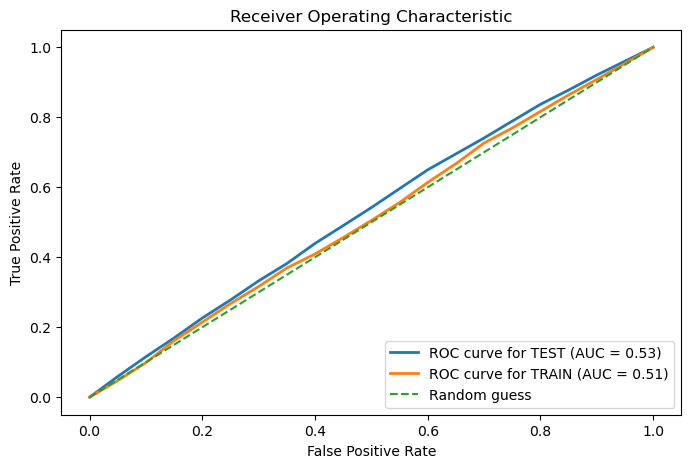

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.49      1.00      0.66      6430
         1.0       0.00      0.00      0.00      6566

    accuracy                           0.49     12996
   macro avg       0.25      0.50      0.33     12996
weighted avg       0.24      0.49      0.33     12996


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       0.49      1.00      0.66     16745
         1.0       0.00      0.00      0.00     17171

    accuracy                           0.49     33916
   macro avg       0.25      0.50      0.33     33916
weighted avg       0.24      0.49      0.33     33916

Test accuracy: 0.49
>> Test precision: 0.00 <<
Test recall: 0.00
Test F1 score: 0.49
Test AUC score: 0.53


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

In [52]:
import xgboost as xgb
#from xgboost import xgbClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#replace -1 by 0 as xgboost expects a boolean target vector (only 0 and 1)
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

# Create a xgb Classifier model
xgb_clf = xgb.XGBClassifier(reg_alpha=11)

xgb_clf.fit(X_train_scaled, y_train) 

# Use the best model to make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_scaled)

ROC(xgb_clf,X_train,X_test,y_train,y_test)

### Displaying ROC Curve

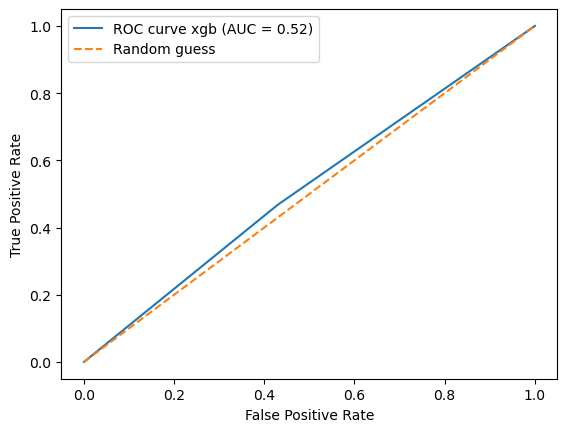

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

xgb_signal_predictions = xgb_clf.predict(X_test_scaled)

#Calculate ROC Curve
xgb_fpr, xgb_tpr, pca_thresholds = roc_curve(y_test, xgb_signal_predictions )

# Calculate the AUC 
xgb_auc = roc_auc_score(y_test, xgb_signal_predictions )

# Plot the ROC curve
plt.plot(xgb_fpr, xgb_tpr, label='ROC curve xgb (AUC = {:.2f})'.format(xgb_auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [54]:
# Create a new empty predictions DataFrame using code provided below.
xgb_predictions_df = pd.DataFrame(index=X_test.index)
xgb_predictions_df["xbg_predicted_signal"] = xgb_signal_predictions
#replace -1 by 0 as xgboost expects a boolean target vector (only 0 and 1)
#xgb_predictions_df = xgb_predictions_df.replace(0,-1)
xgb_predictions_df["actual_returns"] = df["actual_returns"]
xgb_predictions_df["xgb_trading_algorithm_returns"] = xgb_predictions_df["actual_returns"] * xgb_predictions_df["xbg_predicted_signal"]
xgb_predictions_df = xgb_predictions_df.sort_index()
xgb_predictions_df.head()

,xbg_predicted_signal,actual_returns,xgb_trading_algorithm_returns
timestamp,,,
2019-03-07 05:00:00,0,-0.013693,-0.000000
2019-03-07 06:00:00,1,0.000581,0.000581
2019-03-07 07:00:00,1,0.002179,0.002179
2019-03-07 08:00:00,1,-0.006886,-0.006886
2019-03-07 09:00:00,1,-0.001241,-0.001241


<Axes: xlabel='timestamp'>

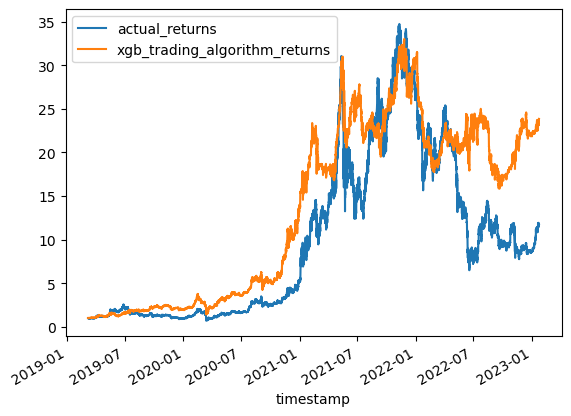

In [55]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + xgb_predictions_df[["actual_returns", "xgb_trading_algorithm_returns"]]).cumprod().plot()

In [56]:
'''
# Create the classifier model
from sklearn.svm import NuSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create NuSVC classifier
svm_model = NuSVC(nu=0.5, probability= True, kernel='rbf')

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

ROC(svm_model,X_train_scaled, X_test_scaled, y_train, y_test)
'''

"\n# Create the classifier model\nfrom sklearn.svm import NuSVC, SVC\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Create NuSVC classifier\nsvm_model = NuSVC(nu=0.5, probability= True, kernel='rbf')\n\n# Fit the model to the data using X_train_scaled and y_train\nsvm_model = svm_model.fit(X_train_scaled, y_train)\n\nROC(svm_model,X_train_scaled, X_test_scaled, y_train, y_test)\n"

In [57]:
'''
# Import libraries
from catboost import CatBoostClassifier
# Initialize the CatBoost model

cb_clf = CatBoostClassifier(iterations=2000,random_state=seed  ,l2_leaf_reg=3)

# Train the model on the training data
cb_clf.fit(X_train_scaled, y_train)

ROC(cb_clf,X_train_scaled, X_test_scaled, y_train, y_test)
'''

'\n# Import libraries\nfrom catboost import CatBoostClassifier\n# Initialize the CatBoost model\n\ncb_clf = CatBoostClassifier(iterations=2000,random_state=seed  ,l2_leaf_reg=3)\n\n# Train the model on the training data\ncb_clf.fit(X_train_scaled, y_train)\n\nROC(cb_clf,X_train_scaled, X_test_scaled, y_train, y_test)\n'